In [16]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# to output everything in a cell instead of only the last output

%matplotlib inline

# standard imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [17]:
SSH_train = np.expand_dims(np.load('trainAVISO-SSH_2000-2010.npy'),3)[:,25:168+25,280-168:,:] #you can use all the region, in here I selected a box of 168*168 size
SSH_test = np.expand_dims(np.load('testAVISO-SSH_2011.npy'),3)[:,25:168+25,280-168:,:] 
#######
Seg_train = np.expand_dims(np.load('trainSegmentation_2000-2010.npy'),3)[:,25:168+25,280-168:,:]
Seg_test = np.expand_dims(np.load('testSegmentation_2011.npy'),3)[:,25:168+25,280-168:,:]
######
SSH_train.shape
SSH_test.shape
#####
Seg_train.shape
Seg_test.shape

(4018, 168, 168, 1)

(365, 168, 168, 1)

(4018, 168, 168, 1)

(365, 168, 168, 1)

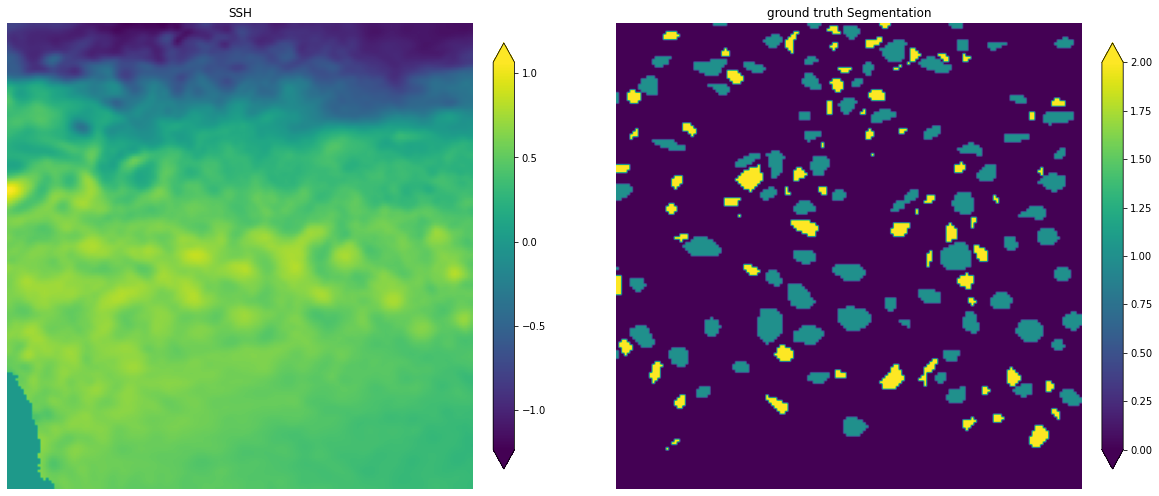

In [18]:
randindex=np.random.randint(0,len(SSH_train))

plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.imshow(SSH_train[randindex,:,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('SSH');

plt.subplot(122)
plt.imshow(Seg_train[randindex,:,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('ground truth Segmentation');

In [19]:
from keras.models import Model, load_model
from keras.layers import Activation, Reshape, Permute, Lambda
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, AlphaDropout, concatenate, Conv2DTranspose
from keras.layers import BatchNormalization, LeakyReLU, add
from keras import utils
from keras.optimizers import Adam
from keras import backend as K
from keras import regularizers
import matplotlib.pyplot as plt
import numpy as np
import pickle
from IPython.display import SVG 
from keras.utils import model_to_dot
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [20]:
Seg_train_categor = utils.to_categorical(np.reshape(Seg_train[:,:,:,0],(4018,168*168)),3)
Seg_train_categor.shape

(4018, 28224, 3)

In [21]:
def ConvBNActi(nf,ker,inputs):
    conv1 = Conv2D(nf, ker, padding="same", kernel_initializer='he_normal', use_bias=False)(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    #conv1 = LeakyReLU(0.3)(conv1)
    return conv1
  
def ConvTranspBNActi(nf,ker,inputs):
    conv1 = Conv2DTranspose(nf, ker, strides=(2, 2), padding="same", kernel_initializer='he_normal', use_bias=False)(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    #conv1 = LeakyReLU(0.3)(conv1)
    return conv1

In [22]:
width = 168
height = 168
nbClass = 3
nf = 16
ker = 3

###################################### INPUT LAYER

img_input = Input(shape=(height, width, 1))
######################################ENCODER

conv1 = ConvBNActi(nf,ker,img_input)
conv1 = ConvBNActi(nf,ker,conv1)
conv1 = Dropout(0.2)(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = ConvBNActi(nf,ker,pool1)
conv2 = ConvBNActi(nf,ker,conv2)
conv2 = Dropout(0.3)(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = ConvBNActi(nf,ker,pool2)
conv3 = ConvBNActi(nf,ker,conv3)
conv3 = Dropout(0.4)(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

#######################################center

convC = ConvBNActi(nf,ker,pool3)
convC = ConvBNActi(nf,ker,convC)
convC = Dropout(0.5)(convC)

#######################################DECODER

#up3 = concatenate([ConvTranspBNActi(nf,ker,convC), conv3])
up3 = concatenate([UpSampling2D((2,2))(convC), conv3])
decod3 = ConvBNActi(nf,ker,up3)
decod3 = ConvBNActi(nf,ker,decod3)
decod3 = Dropout(0.4)(decod3)



#up2 = concatenate([ConvTranspBNActi(nf,ker,decod3), conv2])
up2 = concatenate([UpSampling2D((2,2))(decod3), conv2])
decod2 = ConvBNActi(nf,ker,up2)
decod2 = ConvBNActi(nf,ker,decod2)
decod2 = Dropout(0.3)(decod2)


#up1 = concatenate([ConvTranspBNActi(nf,ker,decod2), conv1])
up1 = concatenate([UpSampling2D((2,2))(decod2), conv1])
decod1 = ConvBNActi(nf,ker,up1)
decod1 = ConvBNActi(nf,ker,decod1)
decod1 = Dropout(0.2)(decod1)


####################################### Segmentation Layer

x = Conv2D(nbClass, (1, 1), padding="valid", use_bias=False)(decod1) 
x = Reshape((height * width, nbClass))(x) 
x = Activation("softmax")(x)
eddynet = Model(img_input, x)

eddynet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 168, 168, 1)]        0         []                            
                                                                                                  
 conv2d_15 (Conv2D)          (None, 168, 168, 16)         144       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_14 (Ba  (None, 168, 168, 16)         64        ['conv2d_15[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_15 (Activation)  (None, 168, 168, 16)         0         ['batch_normalization_14

                                                                                                  
 dropout_10 (Dropout)        (None, 21, 21, 16)           0         ['activation_22[0][0]']       
                                                                                                  
 up_sampling2d_3 (UpSamplin  (None, 42, 42, 16)           0         ['dropout_10[0][0]']          
 g2D)                                                                                             
                                                                                                  
 concatenate_3 (Concatenate  (None, 42, 42, 32)           0         ['up_sampling2d_3[0][0]',     
 )                                                                   'dropout_9[0][0]']           
                                                                                                  
 conv2d_23 (Conv2D)          (None, 42, 42, 16)           4608      ['concatenate_3[0][0]']       
          

__________________________________________________________________________________________________


In [23]:
unique, counts = np.unique(Seg_train, return_counts=True)
dict(zip(unique, counts))

{0: 100434896, 1: 8225760, 2: 4743376}

In [24]:
freq = [np.sum(counts)/j for j in counts]
weightsSeg = [f/np.sum(freq) for f in freq]
weightsSeg

[0.02908370281349848, 0.35510623545649606, 0.6158100617300055]

In [25]:

smooth = 1.  # to avoid zero division

def dice_coef_anti(y_true, y_pred):
    y_true_anti = y_true[:,:,1]
    y_pred_anti = y_pred[:,:,1]
    intersection_anti = K.sum(y_true_anti * y_pred_anti)
    return (2 * intersection_anti + smooth) / (K.sum(y_true_anti)+ K.sum(y_pred_anti) + smooth)

def dice_coef_cyc(y_true, y_pred):
    y_true_cyc = y_true[:,:,2]
    y_pred_cyc = y_pred[:,:,2]
    intersection_cyc = K.sum(y_true_cyc * y_pred_cyc)
    return (2 * intersection_cyc + smooth) / (K.sum(y_true_cyc) + K.sum(y_pred_cyc) + smooth)

def dice_coef_nn(y_true, y_pred):
    y_true_nn = y_true[:,:,0]
    y_pred_nn = y_pred[:,:,0]
    intersection_nn = K.sum(y_true_nn * y_pred_nn)
    return (2 * intersection_nn + smooth) / (K.sum(y_true_nn) + K.sum(y_pred_nn) + smooth)
    
def mean_dice_coef(y_true, y_pred):
    return (dice_coef_anti(y_true, y_pred) + dice_coef_cyc(y_true, y_pred) + dice_coef_nn(y_true, y_pred))/3.

def weighted_mean_dice_coef(y_true, y_pred):
    return (0.36*dice_coef_anti(y_true, y_pred) + 0.62*dice_coef_cyc(y_true, y_pred) + 0.02*dice_coef_nn(y_true, y_pred))
  
def dice_coef_loss(y_true, y_pred):
    return 1 - weighted_mean_dice_coef(y_true, y_pred)

In [26]:
eddynet.compile(optimizer=Adam(learning_rate=1e-3), loss=dice_coef_loss,
                metrics=['categorical_accuracy', mean_dice_coef, weighted_mean_dice_coef])

In [27]:
modelcheck = ModelCheckpoint('./weights/eddynetfirst.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
reducecall = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=1, mode='auto', min_delta=1e-30, min_lr=1e-30)


histeddynet=eddynet.fit(SSH_train, Seg_train_categor,
                              epochs=50,
                              batch_size=16,
                              shuffle=True,
                              verbose=1,
                              callbacks=[modelcheck,reducecall],#,MyCallback(alpha,beta),reducecall
                              validation_split=0.2
                              )

Epoch 1/50


2024-06-07 22:15:18.011783: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_7/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


201/201 [==============================] - ETA: 0s - loss: 0.6524 - categorical_accuracy: 0.7408 - mean_dice_coef: 0.4914 - weighted_mean_dice_coef: 0.3476
Epoch 1: val_loss improved from inf to 0.61319, saving model to ./weights/eddynetfirst.h5
201/201 [==============================] - 19s 53ms/step - loss: 0.6524 - categorical_accuracy: 0.7408 - mean_dice_coef: 0.4914 - weighted_mean_dice_coef: 0.3476 - val_loss: 0.6132 - val_categorical_accuracy: 0.8633 - val_mean_dice_coef: 0.5613 - val_weighted_mean_dice_coef: 0.3872 - lr: 0.0010
Epoch 2/50
201/201 [==============================] - ETA: 0s - loss: 0.4912 - categorical_accuracy: 0.8776 - mean_dice_coef: 0.6431 - weighted_mean_dice_coef: 0.5088
Epoch 2: val_loss improved from 0.61319 to 0.53081, saving model to ./weights/eddynetfirst.h5
201/201 [==============================] - 9s 47ms/step - loss: 0.4912 - categorical_accuracy: 0.8776 - mean_dice_coef: 0.6431 - weighted_mean_dice_coef: 0.5088 - val_loss: 0.5308 - val_categorical

200/201 [============================>.] - ETA: 0s - loss: 0.3945 - categorical_accuracy: 0.9054 - mean_dice_coef: 0.7151 - weighted_mean_dice_coef: 0.6055
Epoch 16: val_loss did not improve from 0.41772
201/201 [==============================] - 9s 45ms/step - loss: 0.3945 - categorical_accuracy: 0.9054 - mean_dice_coef: 0.7151 - weighted_mean_dice_coef: 0.6055 - val_loss: 0.4208 - val_categorical_accuracy: 0.8949 - val_mean_dice_coef: 0.6971 - val_weighted_mean_dice_coef: 0.5798 - lr: 0.0010
Epoch 17/50
201/201 [==============================] - ETA: 0s - loss: 0.3924 - categorical_accuracy: 0.9059 - mean_dice_coef: 0.7166 - weighted_mean_dice_coef: 0.6076
Epoch 17: val_loss improved from 0.41772 to 0.41768, saving model to ./weights/eddynetfirst.h5
201/201 [==============================] - 9s 46ms/step - loss: 0.3924 - categorical_accuracy: 0.9059 - mean_dice_coef: 0.7166 - weighted_mean_dice_coef: 0.6076 - val_loss: 0.4177 - val_categorical_accuracy: 0.8915 - val_mean_dice_coef: 0

Epoch 32/50
200/201 [============================>.] - ETA: 0s - loss: 0.3795 - categorical_accuracy: 0.9094 - mean_dice_coef: 0.7257 - weighted_mean_dice_coef: 0.6205
Epoch 32: val_loss did not improve from 0.41542
201/201 [==============================] - 9s 46ms/step - loss: 0.3794 - categorical_accuracy: 0.9094 - mean_dice_coef: 0.7257 - weighted_mean_dice_coef: 0.6206 - val_loss: 0.4176 - val_categorical_accuracy: 0.8946 - val_mean_dice_coef: 0.6998 - val_weighted_mean_dice_coef: 0.5830 - lr: 0.0010
Epoch 33/50
201/201 [==============================] - ETA: 0s - loss: 0.3790 - categorical_accuracy: 0.9096 - mean_dice_coef: 0.7261 - weighted_mean_dice_coef: 0.6210
Epoch 33: val_loss did not improve from 0.41542
201/201 [==============================] - 9s 45ms/step - loss: 0.3790 - categorical_accuracy: 0.9096 - mean_dice_coef: 0.7261 - weighted_mean_dice_coef: 0.6210 - val_loss: 0.4162 - val_categorical_accuracy: 0.8919 - val_mean_dice_coef: 0.7002 - val_weighted_mean_dice_coef

Epoch 48/50
201/201 [==============================] - ETA: 0s - loss: 0.3726 - categorical_accuracy: 0.9112 - mean_dice_coef: 0.7306 - weighted_mean_dice_coef: 0.6274
Epoch 48: val_loss did not improve from 0.41534
201/201 [==============================] - 9s 46ms/step - loss: 0.3726 - categorical_accuracy: 0.9112 - mean_dice_coef: 0.7306 - weighted_mean_dice_coef: 0.6274 - val_loss: 0.4221 - val_categorical_accuracy: 0.8902 - val_mean_dice_coef: 0.6961 - val_weighted_mean_dice_coef: 0.5784 - lr: 0.0010
Epoch 49/50
201/201 [==============================] - ETA: 0s - loss: 0.3721 - categorical_accuracy: 0.9116 - mean_dice_coef: 0.7310 - weighted_mean_dice_coef: 0.6279
Epoch 49: val_loss did not improve from 0.41534
201/201 [==============================] - 9s 46ms/step - loss: 0.3721 - categorical_accuracy: 0.9116 - mean_dice_coef: 0.7310 - weighted_mean_dice_coef: 0.6279 - val_loss: 0.4166 - val_categorical_accuracy: 0.8901 - val_mean_dice_coef: 0.6997 - val_weighted_mean_dice_coef

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

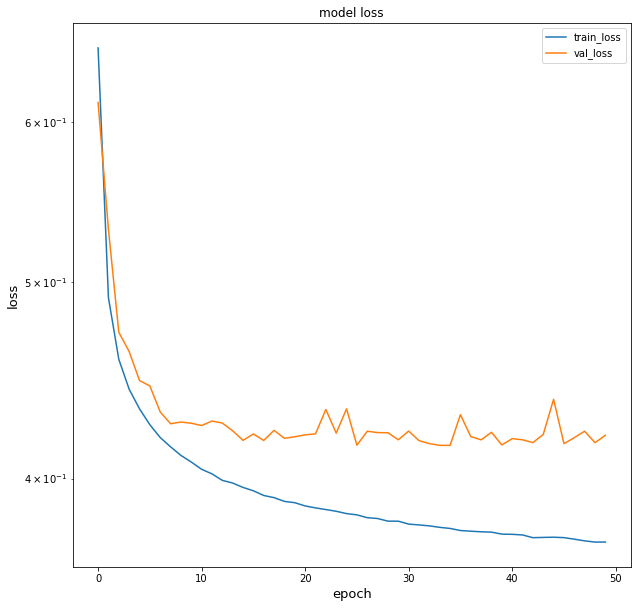

In [29]:
plt.figure(figsize=(10, 10))
plt.semilogy(eddynet.history.history['loss'])
plt.semilogy(eddynet.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss', fontsize = '13')
plt.xlabel('epoch', fontsize = '13')
plt.legend(['train_loss', 'val_loss'], loc='upper right');
plt.savefig("results/loss_orig", facecolor='white')

1/1 [==============================] - 0s 350ms/step


<Figure size 1440x720 with 0 Axes>

<Axes: >

(-0.5, 167.5, 167.5, -0.5)

Text(0.5, 1.0, 'SSH')

<Axes: >

(-0.5, 167.5, 167.5, -0.5)

Text(0.5, 1.0, 'Eddynet Segmentation')

<Axes: >

(-0.5, 167.5, 167.5, -0.5)

Text(0.5, 1.0, 'ground truth Segmentation')

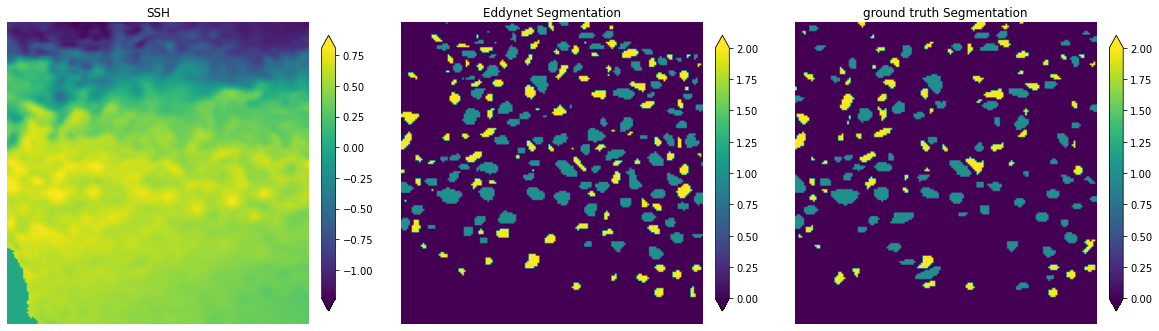

In [30]:
randindex=np.random.randint(0,len(SSH_train))
predictedSEGM=eddynet.predict(np.reshape(SSH_train[randindex,:,:],(1,height,width,1)))
predictedSEGMimage = np.reshape(predictedSEGM.argmax(2),(height,width))

plt.figure(figsize=(20, 10))

plt.subplot(131)
plt.imshow(SSH_train[randindex,:,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('SSH');

plt.subplot(132)
plt.imshow(predictedSEGMimage, cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('Eddynet Segmentation');

plt.subplot(133)
plt.imshow(Seg_train[randindex,:,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('ground truth Segmentation');
plt.savefig("results/segmentation_orig", facecolor='white')